In [1]:
import pickle
import os
import glob
from functools import reduce
import copy
import pdb
import zipfile

from addict import Dict
import numpy as np
import networkx as nx
from datetime import datetime
from uncertainties import ufloat
from persistqueue import PDict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import utils

## Data Logistics

In [2]:
EXPERIMENTS_V0 = {
    "BLOOMING-PLANET-214C": "../src/covid19sim/output/sim_v2_people-500_days-30_init-0.01_seed-0_20200506-202417/",
    "BLOOMING-PLANET-214B": "../src/covid19sim/output/sim_v2_people-500_days-30_init-0.01_seed-0_20200506-195806/",
    "BLOOMING-PLANET-214A": "../src/covid19sim/output/sim_v2_people-500_days-30_init-0.01_seed-0_20200506-190449/",
    "BLOOMING-PLANET-214": "../src/covid19sim/output/sim_v2_people-500_days-30_init-0.01_seed-0_20200506-180727/",
    "WANDERING-BEE-211A": "../src/covid19sim/output/sim_v2_people-500_days-30_init-0.01_seed-0_20200506-145409/",
    "WANDERING-BEE-211": "../src/covid19sim/output/sim_v2_people-500_days-30_init-0.01_seed-0_20200506-131230/",
    "LUNAR-VOICE": "../src/covid19sim/output/sim_v2_people-500_days-30_init-0.01_seed-0_20200506-111206/", 
    "SHIPMENT-0": "../src/covid19sim/output/sim_v2_people-500_days-30_init-0.01_seed-0_20200505-215349/",
    "TRACING-O3": "../src/covid19sim/output/sim_v2_people-500_days-30_init-0.01_seed-0_20200505-222248/",
}


EXPERIMENTS_V1 = {
    "FRESH-SNOWFLAKE-224B": "../src/covid19sim/output/sim_v2_people-500_days-15_init-0.025_seed-0_20200511-145219/",
    "MORNING-SWEEP-25B": "../src/covid19sim/output/sim_v2_people-500_days-15_init-0.025_seed-0_20200511-143348/",
    "FRESH-SNOWFLAKE-224E": "../src/covid19sim/output/sim_v2_people-500_days-15_init-0.025_seed-0_20200511-140927/",
    "FRESH-SNOWFLAKE-224C": "../src/covid19sim/output/sim_v2_people-500_days-15_init-0.025_seed-0_20200511-135747/",
    "FRESH-SNOWFLAKE-224A": "../src/covid19sim/output/sim_v2_people-500_days-15_init-0.025_seed-0_20200511-134735/",
    "MORNING-SWEEP-25A": "../src/covid19sim/output/sim_v2_people-500_days-15_init-0.025_seed-0_20200511-133416/",
    "MORNING-SWEEP-25": "../src/covid19sim/output/sim_v2_people-500_days-15_init-0.025_seed-0_20200511-131022/",    
    "FRESH-SNOWFLAKE-224": "../src/covid19sim/output/sim_v2_people-500_days-15_init-0.025_seed-0_20200511-105704/",
    "ORACLE": "../src/covid19sim/output/sim_v2_people-500_days-15_init-0.025_seed-0_20200511-115124/",
    "TRACING-O1": "../src/covid19sim/output/sim_v2_people-500_days-15_init-0.025_seed-0_20200511-183609/",
    "TRACING-O2": "../src/covid19sim/output/sim_v2_people-500_days-15_init-0.025_seed-0_20200511-183206/",
}

In [3]:
RISK_MODEL = "TRACING-O1"

data_config = Dict()
data_config.root_dir = EXPERIMENTS_V1[RISK_MODEL]
data_config.pdict_dir = "./pdicts"

In [4]:
def load_logs(config=None):
    config = config or data_config
    # Read files in log dir and sort them by time
    archive_path = os.path.join(config.root_dir, "data.zip")
    with zipfile.ZipFile(archive_path, mode="r") as zf: 
        files = sorted(zf.namelist())
        # Load 'em up
        logs = []
        for file in files: 
            with zf.open(file, "r") as f: 
                logs.extend(pickle.load(f))
        return logs

In [5]:
def load_human_day(day_idx, human_idx, config=None): 
    config = config or data_config
    path = os.path.join(config.root_dir, "daily_outputs", 
                        str(day_idx), str(human_idx), 
                        "daily_human.pkl")
    with open(path, "rb") as f: 
        info = pickle.load(f)
    return info

In [6]:
def get_encounter_logs(logs=None): 
    logs = load_logs() if logs is None else logs
    encounter_logs = [log for log in logs if log["event_type"] == "encounter"]
    return encounter_logs

In [7]:
encounter_logs = get_encounter_logs()

In [43]:
logs = load_logs()

In [ ]:
logs

## Construct an Encounter Graph

Encounter graph is a multigraph, where nodes are humans and edges are encounters between humans. Human may have multiple encounters with each other, which is why we have a multi-graph at hand. 

In [10]:
def make_encounter_graph(encounter_logs=None): 
    encounter_logs = encounter_logs or get_encounter_logs()
    encounter_graph = nx.MultiDiGraph()
    for encounter_log in encounter_logs: 
        # Ids
        human1_id = encounter_log["payload"]["unobserved"]["human1"]["human_id"]
        human2_id = encounter_log["payload"]["unobserved"]["human2"]["human_id"]
        # Write states
        human1_state = Dict()
        human2_state = Dict()
        # Infection status
        human1_state.is_infected = encounter_log["payload"]["unobserved"]["human1"]["infection_timestamp"] is not None
        human2_state.is_infected = encounter_log["payload"]["unobserved"]["human2"]["infection_timestamp"] is not None
        human1_state.got_exposed = encounter_log["payload"]["unobserved"]["human1"]["got_exposed"]
        human2_state.got_exposed = encounter_log["payload"]["unobserved"]["human2"]["got_exposed"]
        human1_state.caused_exposure = encounter_log["payload"]["unobserved"]["human1"]["exposed_other"]
        human2_state.caused_exposure = encounter_log["payload"]["unobserved"]["human2"]["exposed_other"]
        # Health and symptoms
        human1_state.symptoms = encounter_log["payload"]["unobserved"]["human1"]["symptoms"]
        human2_state.symptoms = encounter_log["payload"]["unobserved"]["human2"]["symptoms"]
        human1_state.infectiousness = encounter_log["payload"]["unobserved"]["human1"]["infectiousness"]
        human2_state.infectiousness = encounter_log["payload"]["unobserved"]["human2"]["infectiousness"]
        # Risk
        human1_state.risk = encounter_log["payload"]["unobserved"]["human1"]["risk"]
        human2_state.risk = encounter_log["payload"]["unobserved"]["human2"]["risk"]
        human1_state.risk_level = encounter_log["payload"]["unobserved"]["human1"]["risk_level"]
        human2_state.risk_level = encounter_log["payload"]["unobserved"]["human2"]["risk_level"]
        # Recommendations
        human1_state.rec_level = encounter_log["payload"]["unobserved"]["human1"]["rec_level"]
        human2_state.rec_level = encounter_log["payload"]["unobserved"]["human2"]["rec_level"]
        # Write stuff out
        encounter_graph.add_edge(human1_id, human2_id, encounter_log["time"], 
                                 human1_state=human1_state, human2_state=human2_state)
    return encounter_graph

The `filter_encounter_graph` function makes a new encounter graph from an existing one by keeping only the encounters that happen between the specified time limits (and removing all other encounters). 

In [11]:
def filter_encounter_graph(graph, from_time, to_time): 
    filtered = nx.MultiDiGraph()
    filtered.add_nodes_from(graph.nodes)
    for h1, h2, time in graph.edges: 
        if from_time <= time <= to_time: 
            filtered.add_edge(h1, h2, time, **graph.edges[h1, h2, time])
    return filtered

The `remove_encounter_graph_nodes` function removes nodes (and all edges) in the graph depending on a `condition_fn`. The `condition_fn` takes as input `human1_state` and `human2_state`, and outputs a bool saying if the condition is satisfied. For a given `human1` and for `reduction="and"`, if the condition is satisfied for all encounters with all encounter partners, the `human1` is marked for removal. Likewise, if `reduction="or"`, the human is marked for removal if the condition is satisfied for any encounter with any partner. `reduction` can also be a lambda. 

In [12]:
def remove_encounter_graph_nodes(graph, condition_fn, reduction=(lambda x, y: x and y)): 
    # Validate inputs
    assert callable(condition_fn)
    if isinstance(reduction, str): 
        if reduction == "and": 
            reduction = lambda x, y: x and y
        elif reduction == "or":
            reduction = lambda x, y: x or y
        else:
            raise ValueError
    assert callable(reduction)
    # Go
    node_condition_mapping = Dict()
    for node in graph.nodes: 
        conditions = []
        for neighbor in graph[node]: 
            for keys in graph[node][neighbor]: 
                conditions.append(condition_fn(**graph[node][neighbor][keys]))
        # pdb.set_trace()
        reduce(reduction, conditions)
        assert node not in node_condition_mapping
        node_condition_mapping[node] = reduce(reduction, conditions)
    nodes_to_remove = [node for node, cond in node_condition_mapping.items() if cond]
    trimmed = copy.deepcopy(graph)
    trimmed.remove_nodes_from(nodes_to_remove)
    return trimmed

`filter_edges` keeps an edge only if `condition_fn(time, human1_state, human2_state)` returns True. 

In [13]:
def filter_edges(graph, condition_fn): 
    assert callable(condition_fn)
    trimmed = nx.MultiDiGraph()
    for u, v, d in graph.edges: 
        if condition_fn(d, **graph[u][v][d]): 
            trimmed.add_edge(u, v, d, **graph[u][v][d])
    return trimmed

`collate_edges` summarizes multiple edges to a single edge with a `collate_fn`. The `collate_fn` takes as input all edges between any two nodes. 

In [14]:
def collate_edges(graph, collate_fn): 
    trimmed = nx.MultiDiGraph()
    for u in graph.nodes: 
        for v in graph[u]: 
            new_d, new_attries = collate_fn(graph[u][v])
            trimmed.add_edge(u, v, new_d, **new_attries)
    return trimmed

In [15]:
def to_digraph(graph, attry_extractor=(lambda human1_state, human2_state: {})): 
    digraph = nx.DiGraph()
    for u in graph: 
        for v in graph[u]: 
            assert len(graph[u][v]) == 1
            time = list(graph[u][v].keys())[0]
            extra_attries = attry_extractor(**graph[u][v][time])
            digraph.add_edge(u, v, time=time, **extra_attries)
    return digraph


def to_concat_digraph(graph, attry_extractor=(lambda human1_state, human2_state: {})):
    digraph = nx.DiGraph()
    for u in graph: 
        for v in graph[u]: 
            attry_dicts = [attry_extractor(**graph[u][v][time]) for time in graph[u][v].keys()]
            concat_attry_dict = {key: [d[key] for d in attry_dicts] for key in attry_dicts[0].keys()}
            concat_attry_dict.update({"time": list(graph[u][v].keys())})
            digraph.add_edge(u, v, **concat_attry_dict)
    return digraph

### Functional Filters

It should be able to manipulate the graph with just these filters.

In [16]:
# Node removal
def is_not_infected(human1_state, human2_state): 
    return not human1_state["is_infected"]

# Edge filtering
def is_contagion(time, human1_state, human2_state): 
    return human2_state["got_exposed"]

def is_contagion_without_symptoms(time, human1_state, human2_state): 
    return (is_contagion(time, human1_state, human2_state) and 
            len(human1_state["symptoms"]) == 0)

def is_contagion_with_symptoms(time, human1_state, human2_state): 
    return (is_contagion(time, human1_state, human2_state) and 
            len(human1_state["symptoms"]) > 0)

# Collating
def keep_most_recent(edge_spec): 
    most_recent_date = max(list(edge_spec.keys()))
    most_recent_attries = edge_spec[most_recent_date]
    return most_recent_date, most_recent_attries

def keep_least_recent(edge_spec): 
    least_recent_date = min(list(edge_spec.keys()))
    least_recent_attries = edge_spec[least_recent_date]
    return least_recent_date, least_recent_attries

### Utils

In [17]:
def histogram_partition(x, nbin):
    size = len(x)
    sorted_x = np.sort(x)
    return sorted_x[::size//nbin]
    

## Playtime

In [18]:
encounter_graph = make_encounter_graph(encounter_logs)

In [19]:
INTERVAL_START = datetime(2020, 2, 28)
INTERVAL_STOP = datetime(2020, 3, 12)
eg_at_interval = filter_encounter_graph(encounter_graph, INTERVAL_START, INTERVAL_STOP)

In [20]:
contagion_graph = filter_edges(eg_at_interval, is_contagion_without_symptoms)

In [21]:
print(f"Num Nodes in CG: {len(contagion_graph.nodes)}")
print(f"Num Edges in CG: {len(contagion_graph.edges)}")

Num Nodes in CG: 55
Num Edges in CG: 51


In [22]:
VERBOSE = False
for u, v, d in sorted(contagion_graph.edges, key=lambda x: x[-1]): 
    if VERBOSE:
        print(f"{u} --> {v} (Time: {d})")

In [23]:
contagion_digraph = to_digraph(contagion_graph, 
                               lambda human1_state, human2_state: dict(exposer_risk=human1_state["risk"], 
                                                                       exposer_risk_level=human1_state["risk_level"], 
                                                                       exposer_rec_level=human1_state["rec_level"]))

In [24]:
encounter_digraph = to_concat_digraph(eg_at_interval, 
                                      lambda human1_state, human2_state: dict(exposer_risk=human1_state["risk"], 
                                                                              exposer_risk_level=human1_state["risk_level"], 
                                                                              exposer_rec_level=human1_state["rec_level"]))

### Risk and Recommendation Levels at Exposure

The following plots show the distributions over risk and recommendation levels of the infector at the time of exposure. This must be interpreted carefully, because tracing might change the distribution over the infectors (via intervention). It is much more meaningful if the distribution is observational and therefore stationary. 

In [25]:
raw_risks_all = [_risk for u, v in encounter_digraph.edges for _risk in encounter_digraph[u][v]["exposer_risk"]]
raw_risks_at_exposure = [contagion_digraph[u][v]["exposer_risk"] for u, v in contagion_digraph.edges]
risks_at_exposure = [contagion_digraph[u][v]["exposer_risk_level"] for u, v in contagion_digraph.edges]
recs_at_exposure = [contagion_digraph[u][v]["exposer_rec_level"] for u, v in contagion_digraph.edges]

mean_raw_risk_all = np.mean(raw_risks_all)
std_raw_risk_all = np.std(raw_risks_all)
median_raw_risk_all = np.median(raw_risks_all)

mean_risk_at_exposure = np.mean(risks_at_exposure)
max_risk_at_exposure = np.max(risks_at_exposure)
median_risk_at_exposure = np.median(risks_at_exposure)
std_risk_at_exposure = np.std(risks_at_exposure)

mean_rec_at_exposure = np.mean(recs_at_exposure)
median_rec_at_exposure = np.median(recs_at_exposure)
std_rec_at_exposure = np.std(recs_at_exposure)

print(f"Mean Risk +/- Std: {mean_risk_at_exposure} +/- {std_risk_at_exposure}")
print(f"Mean/Max Risk: {100 * mean_risk_at_exposure/max_risk_at_exposure:.2f}%")
print(f"Median Risk (Exposed): {median_risk_at_exposure}")

print("-------")
print(f"Mean Population Risks +/- Std: {mean_raw_risk_all} +/- {std_raw_risk_all}")
print(f"Median Population Risks: {median_raw_risk_all}")
print(f"Pseudo-lift: {mean_risk_at_exposure / mean_raw_risk_all}")
print(f"Pseudo-lift (GEP): {ufloat(mean_risk_at_exposure, std_risk_at_exposure) / ufloat(mean_raw_risk_all, std_raw_risk_all)}")
print(f"Pseudo-lift (Median): {median_risk_at_exposure / median_raw_risk_all}")

Mean Risk +/- Std: 0.1568627450980392 +/- 0.6062597974015808
Mean/Max Risk: 5.23%
Median Risk (Exposed): 0.0
-------
Mean Population Risks +/- Std: 0.0015869490642197006 +/- 0.031621081712220625
Median Population Risks: 0.0
Pseudo-lift: 98.8454819595412
Pseudo-lift (GEP): (0.1+/-2.0)e+03
Pseudo-lift (Median): nan


/Users/nrahaman/miniconda3/envs/robo1437/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


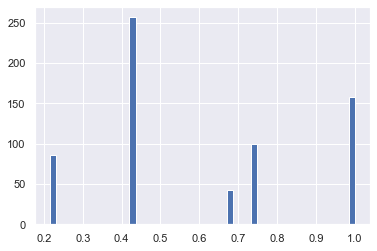

In [52]:
plt.figure()
plt.hist(raw_risks_all[raw_risks_all > 0.04], bins=50)
plt.show()

In [48]:
raw_risks_all = np.asarray(raw_risks_all)
raw_risks_all[raw_risks_all > 0].shape

(2718,)

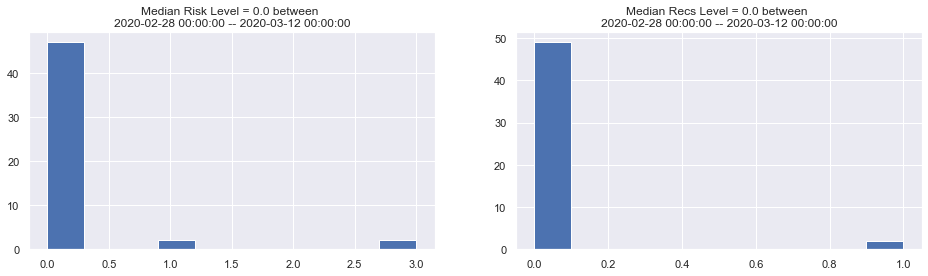

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].set_title(f"Median Risk Level = {median_risk_at_exposure} between \n{INTERVAL_START} -- {INTERVAL_STOP}")
axs[0].hist(risks_at_exposure)
axs[1].set_title(f"Median Recs Level = {median_risk_at_exposure} between \n{INTERVAL_START} -- {INTERVAL_STOP}")
axs[1].hist(recs_at_exposure)
plt.show()

Now, we try to figure out how well we can partition the histogram over infections. 

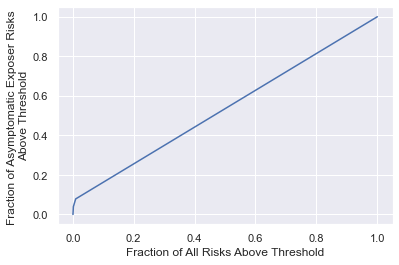

In [39]:
# thresholds = (list(np.linspace(min(raw_risks_all), max(raw_risks_all) + 1/100, 100)) + 
#               [np.percentile(raw_risks_at_exposure, x) for x in np.linspace(0, 100, 20)] + 
#               [np.percentile(raw_risks_all, x) for x in np.linspace(0, 100, 20)])
# thresholds = np.array(sorted(thresholds))

thresholds = np.linspace(0, 1, 1000)

percentiles = np.array([(raw_risks_all >= thresh).mean() for thresh in thresholds])
percentile_curve = np.array([(raw_risks_at_exposure >= thresh).mean() for thresh in thresholds])
plt.figure()
plt.plot(percentiles, percentile_curve)
plt.ylabel("Fraction of Asymptomatic Exposer Risks \nAbove Threshold")
plt.xlabel("Fraction of All Risks Above Threshold")
plt.show()

# print(f"Average Gradient: {np.diff(percentile_curve[percentiles < 0.2]).mean()}")

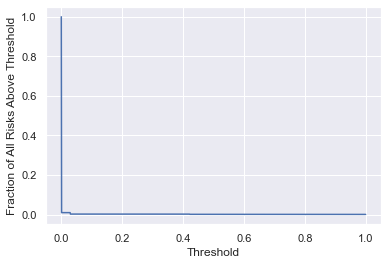

In [42]:
plt.figure()
plt.plot(thresholds, percentiles, label="All Encounters")
plt.xlabel("Threshold")
plt.ylabel("Fraction of All Risks Above Threshold")
plt.show()

In [29]:
percentile_curves = PDict(data_config.pdict_dir, "percentile_curves")
percentile_curves[RISK_MODEL] = (percentiles, percentile_curve)

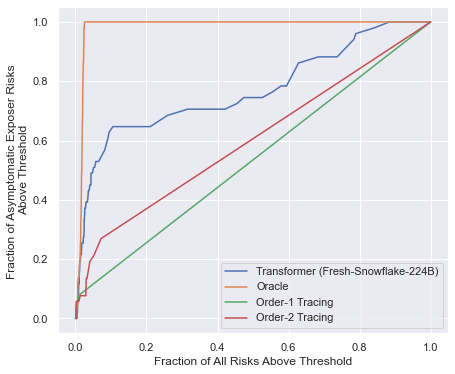

In [63]:
KEY_LABELS = {
#     "MORNING-SWEEP-25B": "Transformer (Morning-Sweep-25B)",
#     "MORNING-SWEEP-25": "Transformer (Morning-Sweep-25)",
#     "FRESH-SNOWFLAKE-224E": "Transformer (Fresh-Snowflake-224E)",
#     "FRESH-SNOWFLAKE-224C": "Transformer (Fresh-Snowflake-224C)",
    "FRESH-SNOWFLAKE-224B": "Transformer (Fresh-Snowflake-224B)",
#     "FRESH-SNOWFLAKE-224A": "Transformer (Fresh-Snowflake-224A)",
#     "FRESH-SNOWFLAKE-224": "Transformer (Fresh-Snowflake-224)",
    "ORACLE": "Oracle",
    "TRACING-O1": "Order-1 Tracing",
    "TRACING-O2": "Order-2 Tracing",
#     "TRACING-O3": "Order-3 Tracing",
}

plt.figure(figsize=(7, 6))
for _risk_model in KEY_LABELS.keys():
    try:
        percentiles, percentile_curve = percentile_curves[_risk_model]
        plt.plot(percentiles, percentile_curve, label=KEY_LABELS[_risk_model])
    except KeyError: 
        continue
plt.ylabel("Fraction of Asymptomatic Exposer Risks \nAbove Threshold")
plt.xlabel("Fraction of All Risks Above Threshold")
plt.legend()
plt.show()

In [31]:
cutoff = 1.
for _risk_model in KEY_LABELS.keys(): 
    percentiles, percentile_curve = percentile_curves[_risk_model]
    mask = percentiles <= cutoff
    _masked_percentile_curve = percentile_curve[mask]
    _masked_percentiles = percentiles[mask]
    print(f"{_risk_model}: {-np.trapz(_masked_percentile_curve, _masked_percentiles)}")

FRESH-SNOWFLAKE-224B: 0.7695839161221196
ORACLE: 0.9835017352618232
TRACING-O1: 0.5345102600143462
TRACING-O2: 0.5997734648853958


In [32]:
for cutoff in np.linspace(0, 0.2, 5):
    print(f"----- Cutoff: {cutoff * 100}% -----")
    for _risk_model in KEY_LABELS.keys(): 
        percentiles, percentile_curve = percentile_curves[_risk_model]
        mask = percentiles <= cutoff
        _masked_percentile_curve = percentile_curve[mask]
        _masked_percentiles = percentiles[mask]
        print(f"{_risk_model}: {-np.trapz(_masked_percentile_curve, _masked_percentiles)}")

----- Cutoff: 0.0% -----
FRESH-SNOWFLAKE-224B: -0.0
ORACLE: -0.0
TRACING-O1: -0.0
TRACING-O2: -0.0
----- Cutoff: 5.0% -----
FRESH-SNOWFLAKE-224B: 0.013411022830106714
ORACLE: 0.01045365067470725
TRACING-O1: 0.00045982444574361775
TRACING-O2: 0.0036703719816564132
----- Cutoff: 10.0% -----
FRESH-SNOWFLAKE-224B: 0.03907274656270447
ORACLE: 0.01045365067470725
TRACING-O1: 0.00045982444574361775
TRACING-O2: 0.010783116207516444
----- Cutoff: 15.000000000000002% -----
FRESH-SNOWFLAKE-224B: 0.06260607239982843
ORACLE: 0.01045365067470725
TRACING-O1: 0.00045982444574361775
TRACING-O2: 0.010783116207516444
----- Cutoff: 20.0% -----
FRESH-SNOWFLAKE-224B: 0.08007749586774915
ORACLE: 0.01045365067470725
TRACING-O1: 0.00045982444574361775
TRACING-O2: 0.010783116207516444


### Infection Chains

The following plots show the infection trees together with the risk level of infectors at the time of infection. 

In [33]:
contagion_subgraphs = [contagion_digraph.subgraph(sg) 
                       for sg in nx.weakly_connected_components(contagion_digraph)]

In [34]:
REC_CMAP = {0: "g", 1: "b", 2: "orange", 3: "red"}

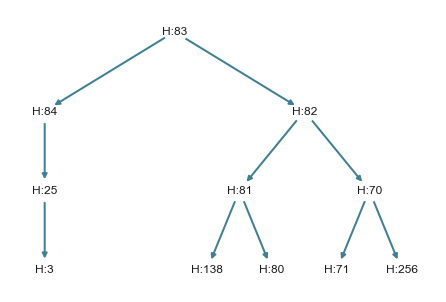

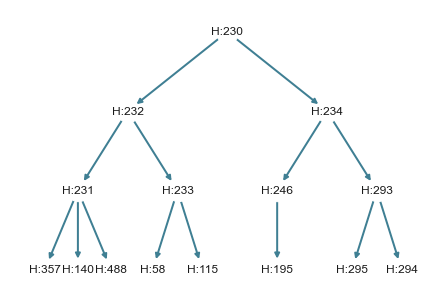

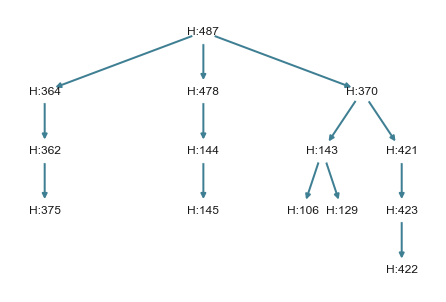

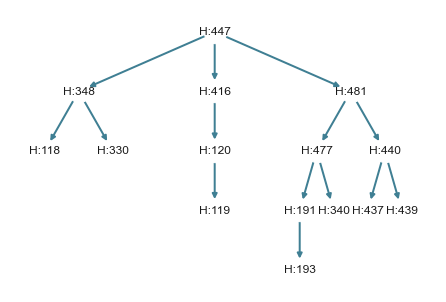

In [35]:
for k in range(len(contagion_subgraphs)):
    pos = utils.hierarchy_pos(contagion_subgraphs[k])
    edge_labels = {(u, v): "[{} $\leftarrow$ {:.2f}]".format(contagion_subgraphs[k][u][v]["exposer_risk_level"], 
                                                contagion_subgraphs[k][u][v]["exposer_risk"],) 
                   for u, v in contagion_subgraphs[k].edges}
    edge_colors = [contagion_subgraphs[k][u][v]["exposer_risk"]
                   for u, v in contagion_subgraphs[k].edges]
    edge_vmin, edge_vmax = np.percentile(raw_risks_all, 1), np.percentile(raw_risks_all, 99)
    nx.draw(contagion_subgraphs[k], 
            pos=pos, 
            labels={node: "H:" + node.split(":")[-1] for node in contagion_subgraphs[k].nodes},
            with_labels=True, node_size=500, node_color="w", 
            edge_color=edge_colors, width=2, edge_cmap=sns.diverging_palette(220, 20, n=7, as_cmap=True, center="dark"), 
            edge_vmin=edge_vmin, edge_vmax=edge_vmax)
#     nx.draw_networkx_edge_labels(contagion_subgraphs[k], pos, edge_labels, rotate=False)
    plt.show()